# Preparation

## Modules

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import seaborn as sns
# import tensorflow as tf
# import tensorflow_addons as tfa

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, Input, RNN, GRU, Bidirectional, concatenate, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from Feature import Feature
from utils.label import label

import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # For removing alert
print(os.getenv('TF_GPU_ALLOCATOR'))

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

TF_ENABLE_ONEDNN_OPTS=0

df = pd.read_csv("df.csv")


# df = df[['Timestamp', 'Open', 'Close', 'Volumn', 'Timestamp End',
#        'Quote_asset_volume', 'Taker_buy_base_asset_volume','label','price_SMA5',"price_EMA5","price_WMA5","CCI5", "RSI5", "RS5"]]

# plt.figure(figsize=(16,9), dpi=90)
# sns.heatmap(df.corr())
# plt.show()

# ConvSert all dataframes to numpy
train_df = df.iloc[0:int(len(df)*0.8), :]
train_data = train_df.to_numpy()
num_rows_train, num_cols_train = train_data.shape
test_df = df.iloc[int(len(df)*0.8):]
test_data = test_df.to_numpy()
num_rows_test, num_cols_test = test_data.shape

steps = 10

# Make copies of test_data and train_data
test_data_cpy = test_data.copy()
train_data_cpy = train_data.copy()

# MinMaxScaler for training data, we take only {steps} row before to apply MinMaxScaler() in these rows
scaler = MinMaxScaler().fit(train_data_cpy[0:steps])

for i in range(steps, num_rows_train):
    if i % steps == 0:
        scaler = MinMaxScaler().fit(train_data_cpy[i-steps:i])
    train_data[i] = scaler.transform(train_data_cpy[i].reshape(1, -1))

train_data = train_data[steps+1:]
train_df = train_df.iloc[steps+1:,:]


# MinMaxScaler for test data, we take only {steps} row before to apply MinMaxScaler() in these rows
for i in range(num_rows_test):
    if i != 0 and i % steps == 0:
        scaler = MinMaxScaler().fit(test_data_cpy[i-steps:i])
#     if i > steps:
#         scaler = MinMaxScaler(feature_range=(-1,1)).fit(test_data_cpy[i-steps:i])
    test_data[i] = scaler.transform(test_data_cpy[i].reshape(1, -1))
#         del scaler
#     else:
#         scaler = MinMaxScaler(feature_range=(-1,1)).fit(np.array(test_data_cpy[:i].tolist() + train_data_cpy[-steps:].tolist()))
#         test_data[i] = scaler.transform(test_data_cpy[i].reshape(1, -1))
#         del scaler


def split_sequences(data, window_size, label_col_idx):
    x = []
    y = []
    for i in range(0, len(data)-window_size):
        x.append(data[i:i+window_size, :])  # Take window_size rows data before
        # To predict the current value of 'difference' column
        y.append(data[i+window_size, label_col_idx])
    return np.array(x), np.array(y)


train_data = np.asarray(train_data).astype('float32')
test_data = np.asarray(test_data).astype('float32')

x_train, y_train = split_sequences(
    train_data, steps, df.columns.get_loc("label"))
x_test, y_test = split_sequences(
    test_data, steps, df.columns.get_loc("label"))


def accuracy(model, x_np, y_np, data_df):
    def relabel(x):
        if x > 0:
            return 1
        return 0

    # Calculate the predicted values
    pred = model.predict(x_np)

    pred_label = np.vectorize(relabel)(pred)
    diff_label = data_df["label"][-len(pred):].to_numpy().reshape(-1, 1)
    return float(sum(diff_label == pred_label)/len(diff_label))

cuda_malloc_async


In [29]:
num_of_main_layers = 1
num_of_outputs = 10
model_name = str(num_of_main_layers)+"BiLSTM"+str(num_of_outputs)+".h5"

print('Build model %s...' % (model_name))

# model = load_model("1BiLSTM10.h5")

# model = Sequential()

# model.add(LSTM(num_of_outputs, input_shape=(
#     steps, train_df.shape[1]), return_sequences=True))

# model.add(GRU(num_of_outputs, return_sequences=True))

# # model.add(LSTM(num_of_outputs, return_sequences=True))

# # model.add(Dense(16, activation='relu'))

# model.add(Flatten())

# model.add(Dense(1, activation='sigmoid'))

# opt = tf.keras.optimizers.Adam(
#     learning_rate=0.001
# )
# model.compile(
#     loss='binary_crossentropy', 
#     optimizer=opt, 
#     metrics=['accuracy']
# )

# monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5,
#                         verbose=1, mode='auto', restore_best_weights=True)

# # First test fit:
# print("First fit:")
# model.fit(x_train, y_train, batch_size=32, epochs=1)
# model._name = model_name
# model.save(model_name)
# print("Done!")

# print(model.summary())

# train_acc = []
# test_acc = []

# print('Train...')

# def tien_loss(y_true, y_pred):
#     a = y_pred*y_true > 0
#     return abs(y_pred-y_true) + tf.where(a,0.,abs(y_pred-y_true))


# MAX = 2

# for i in range(1, MAX):
#     print("\nLoad %i:" % i)
#     model = load_model(model_name)
#     history = model.fit(x_train, y_train, batch_size=32, validation_data=(x_test, y_test),
#                         epochs=100)
#     # train_acc.append(accuracy(model, x_train, y_train, train_df))
#     # test_acc.append(accuracy(model, x_test, y_test, test_df))
#     model.save(model_name)





good_predict = 0
count = 0
retrain_period = 20
actual_acc = []
m = tf.keras.metrics.BinaryAccuracy()

def pre_label(x):
    if x > 0.5:
        return 1.
    return 0.

all_data_np = np.concatenate((x_train,x_test), axis=0)
all_y_np = np.concatenate((y_train, y_test), axis=0)

for i in range(x_train.shape[0], x_train.shape[0] + len(x_test)-retrain_period, retrain_period):
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    history = model.fit(all_data_np[i-x_train.shape[0]+retrain_period:i+retrain_period, :], all_y_np[i-len(x_train)+retrain_period:i+retrain_period], batch_size=32, validation_data=(x_test[i-len(x_train)+retrain_period:i+retrain_period, :], y_test[i-len(x_train)+retrain_period:i+retrain_period]), epochs=10)
    a = model.predict(x_test[i-x_train.shape[0]+retrain_period:i-x_train.shape[0]+2*retrain_period,:])
    good_predict += sum((np.vectorize(pre_label)
                        (a.reshape((a.shape[0]))) == y_test[i-x_train.shape[0]+retrain_period:i-x_train.shape[0]+2*retrain_period]))/retrain_period
    count += 1
    actual_acc.append(good_predict/count)
    print("Last acc:", good_predict/count)

print("Last acc:", good_predict/count)

# Plot
plt.figure(figsize = (16,9))
plt.plot(history.history['accuracy'], label="Train acc")
plt.plot(actual_acc, label="actual_acc")
# plt.plot(history.history['val_accuracy'], label="Test acc")
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.show()

Build model 1BiLSTM10.h5...
Epoch 1/50
166/166 [==============================] - 2s 6ms/step - loss: 0.1896 - accuracy: 0.9285 - val_loss: 2.4874 - val_accuracy: 0.5088
Epoch 2/50
166/166 [==============================] - 1s 4ms/step - loss: 0.1745 - accuracy: 0.9368 - val_loss: 2.5510 - val_accuracy: 0.5135
Epoch 3/50
166/166 [==============================] - 1s 4ms/step - loss: 0.1648 - accuracy: 0.9390 - val_loss: 2.4631 - val_accuracy: 0.5188
Epoch 4/50
166/166 [==============================] - 1s 4ms/step - loss: 0.1862 - accuracy: 0.9332 - val_loss: 2.5467 - val_accuracy: 0.5127
Epoch 5/50
166/166 [==============================] - 1s 4ms/step - loss: 0.1676 - accuracy: 0.9390 - val_loss: 2.5474 - val_accuracy: 0.5111
Epoch 6/50
166/166 [==============================] - 1s 4ms/step - loss: 0.1583 - accuracy: 0.9400 - val_loss: 2.5669 - val_accuracy: 0.5096
Epoch 7/50
166/166 [==============================] - 1s 4ms/step - loss: 0.1503 - accuracy: 0.9464 - val_loss: 2.6505 -

Epoch 8/50
166/166 [==============================] - 1s 4ms/step - loss: 0.0784 - accuracy: 0.9781 - val_loss: 3.6302 - val_accuracy: 0.5363
Epoch 9/50
166/166 [==============================] - 1s 4ms/step - loss: 0.1049 - accuracy: 0.9640 - val_loss: 3.6596 - val_accuracy: 0.5277
Epoch 10/50
166/166 [==============================] - 1s 4ms/step - loss: 0.0729 - accuracy: 0.9792 - val_loss: 3.6858 - val_accuracy: 0.5238
Epoch 11/50
166/166 [==============================] - 1s 4ms/step - loss: 0.0812 - accuracy: 0.9787 - val_loss: 3.7563 - val_accuracy: 0.5230
Epoch 12/50
166/166 [==============================] - 1s 4ms/step - loss: 0.0648 - accuracy: 0.9838 - val_loss: 3.7407 - val_accuracy: 0.5246
Epoch 13/50
166/166 [==============================] - 1s 4ms/step - loss: 0.0669 - accuracy: 0.9815 - val_loss: 3.7930 - val_accuracy: 0.5246
Epoch 14/50
151/166 [==========================>...] - ETA: 0s - loss: 0.0593 - accuracy: 0.9849

KeyboardInterrupt: 

In [ ]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, Input, RNN, GRU, Bidirectional, concatenate, BatchNormalization, Flatten, SimpleRNN

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from Feature import Feature
from utils.label import label

import logging
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

TF_ENABLE_ONEDNN_OPTS = 0

tf.keras.utils.enable_interactive_logging

df = pd.read_csv("df.csv")

df = df[df["Timestamp"] >= 1609506000000]


# Convert all dataframes to numpy
data_np = df.to_numpy()

# Number of steps
steps = 10

# Make copies of test_data and train_data
data_np_cpy = data_np.copy()

# MinMaxScaler for training data, we take only {steps} row before to apply MinMaxScaler() in these rows
scaler = MinMaxScaler().fit(data_np[0:steps])

for i in range(steps, data_np.shape[0]):
    if i % steps == 0:
        # Recalculate the scaler
        scaler = MinMaxScaler().fit(data_np_cpy[i-steps:i])
    data_np[i] = scaler.transform(data_np_cpy[i].reshape(1, -1))

data_np = np.asarray(data_np).astype('float32')

def accuracy(model, x_np, y_np, data_df):
    def relabel(x):
        if x > 0:
            return 1
        return 0

    # Calculate the predicted values
    pred = model.predict(x_np)

    pred_label = np.vectorize(relabel)(pred)
    diff_label = data_df["label"][-len(pred):].to_numpy().reshape(-1, 1)
    return float(sum(diff_label == pred_label)/len(diff_label))


RNNs = {
    "GRU": GRU,
    "LSTM": LSTM,
    "RNN": SimpleRNN
}


def split_sequences(data, window_size, label_col_idx):
    x = []
    y = []
    for i in range(0, len(data)-window_size):
        x.append(data[i:i+window_size, :])  # Take window_size rows data before
        
        # To predict the current value of 'difference' column
        y.append(data[i+window_size, label_col_idx])
    return np.array(x), np.array(y)


def build_model(num_of_main_layers, name_of_RNN):
    model = Sequential()

    for _ in range(num_of_main_layers-1):
        model.add(RNNs[name_of_RNN](num_of_outputs, input_shape=(
            steps, data_np.shape[1]), return_sequences=True, recurrent_dropout=0.1))

    model.add(RNNs[name_of_RNN](num_of_outputs, input_shape=(
        steps, data_np.shape[1]), return_sequences=False, recurrent_dropout=0.1))

    return model


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10,
                                            verbose=1, mode='auto', restore_best_weights=True)

num_of_outputs = 1


training_period = 5000


def pre_label(x):
    if x > 0.5:
        return 1.
    return 0.


train_data_np, test_data_np = split_sequences(data_np, steps, df.columns.get_loc('label'))


for name_of_RNN in ["LSTM", "GRU", "RNN"]:

    for num_of_main_layers in range(2, 5):

        for retrain_period in [50, 20, 10]:

            model_name = str(num_of_main_layers) + name_of_RNN + \
                str(num_of_outputs) + ".h5"
            
            logging.basicConfig(level=logging.DEBUG, filename="log-%s.log" % (model_name), filemode="a+",
                                format="%(asctime)-15s %(levelname)-8s %(message)s")            
            
            logging.info('Build model %s...' % (model_name))

            model = build_model(num_of_main_layers, name_of_RNN)

            model.compile(
                loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy']
            )

            model.fit(train_data_np[0:10], test_data_np[0:10], batch_size=32, epochs=1)

            logging.info(model.summary())
            
            logging.info('Train...')

            good_predict = 0
            count = 0

            actual_acc = []
            train_acc = []

            for i in range(0, train_data_np.shape[0]-retrain_period, retrain_period):
                
                logging.info(
                    "Step:" + str(i) + "/" + str(train_data_np.shape[0]-retrain_period))
                
                model = build_model(num_of_main_layers, name_of_RNN)

                model.compile(
                    loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy']
                )
                
                next_i = i+training_period

                history = model.fit(train_data_np[i:next_i, :], test_data_np[i:next_i], batch_size=32, \
                                    validation_data=(train_data_np[next_i:next_i+retrain_period, :], test_data_np[next_i:next_i+retrain_period]), epochs=1, callbacks=[callback])
                
                train_acc += history.history["accuracy"]
                break
                a = model.predict(
                    train_data_np[next_i:next_i+retrain_period, :])

                good_predict += sum((np.vectorize(pre_label)
                                    (a.reshape((a.shape[0]))) == test_data_np[next_i:next_i+retrain_period]))/retrain_period
                count += 1

                actual_acc.append(good_predict/count)
                
                logging.info("Last acc:" + str(good_predict/count))

            logging.info("Last acc:" + str(good_predict/1))
            
            # Plot
            plt.figure(figsize=(16, 9))
            plt.plot(train_acc, label="Train accuracy")
            plt.plot(actual_acc, label="Overall test accuracy")
            pd.DataFrame(actual_acc).to_csv("actual_acc_%s_%s.csv" % (retrain_period, model_name))
            pd.DataFrame(train_acc).to_csv("train_acc_%s_%s.csv" % (retrain_period, model_name))
            # plt.plot(history.history['val_accuracy'], label="Test acc")
            plt.legend()
            plt.xlabel("Steps")
            plt.ylabel("Accuracy")

            plt.savefig("retrain_period_%s_%s.png" %
                        (retrain_period, model_name))
            
            plt.savefig("test.png")

2022-06-03 03:16:10.561536: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-03 03:16:11.506537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 03:16:11.527810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 03:16:11.527915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2022-06-03 03:16:12.271750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-03 03:16:12.272824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 03:16:12.272985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 03:16:12.273056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

1/1 [==============================] - 2s 2s/step - loss: 4.9941 - accuracy: 0.2000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 1)             460       
                                                                 
 lstm_1 (LSTM)               (None, 1)                 12        
                                                                 
Total params: 472
Trainable params: 472
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 2s 2s/step - loss: 12.3400 - accuracy: 0.2000
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 1)             460       
                                                                 

In [5]:
df_shift = df.shift(1)

In [6]:
df["Close"]

26604    38292.36
26605    38439.46
26606    38580.59
26607    38555.04
26608    38585.52
           ...   
33250    35889.40
33251    35819.05
33252    35858.28
33253    35795.55
33254    35951.69
Name: Close, Length: 6651, dtype: float64

In [8]:
df_shift["original_close"] = df["Close"]

In [11]:
corr = df_shift.corr()
corr[corr>0.5]

,Timestamp,Open,High,Low,Close,Volumn,Timestamp End,Quote_asset_volume,Number_of_trades,Taker_buy_base_asset_volume,...,ATR26,plus_DI26,minus_DI26,RSI26,RS26,MFI26,price_up_SMA26,price_down_SMA26,Difference,original_close
Timestamp,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Open,NaN,1.000000,0.999534,0.999368,0.999199,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998344
High,NaN,0.999534,1.000000,0.999139,0.999612,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998799
Low,NaN,0.999368,0.999139,1.000000,0.999525,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998689
Close,NaN,0.999199,0.999612,0.999525,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MFI26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.597429,NaN,0.731517,0.670696,1.0,NaN,NaN,NaN,NaN
price_up_SMA26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.624344,0.587035,NaN,0.609380,0.573829,NaN,1.0,NaN,NaN,NaN
price_down_SMA26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.552794,NaN,0.642299,0.535477,NaN,NaN,1.0,NaN,NaN
Difference,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


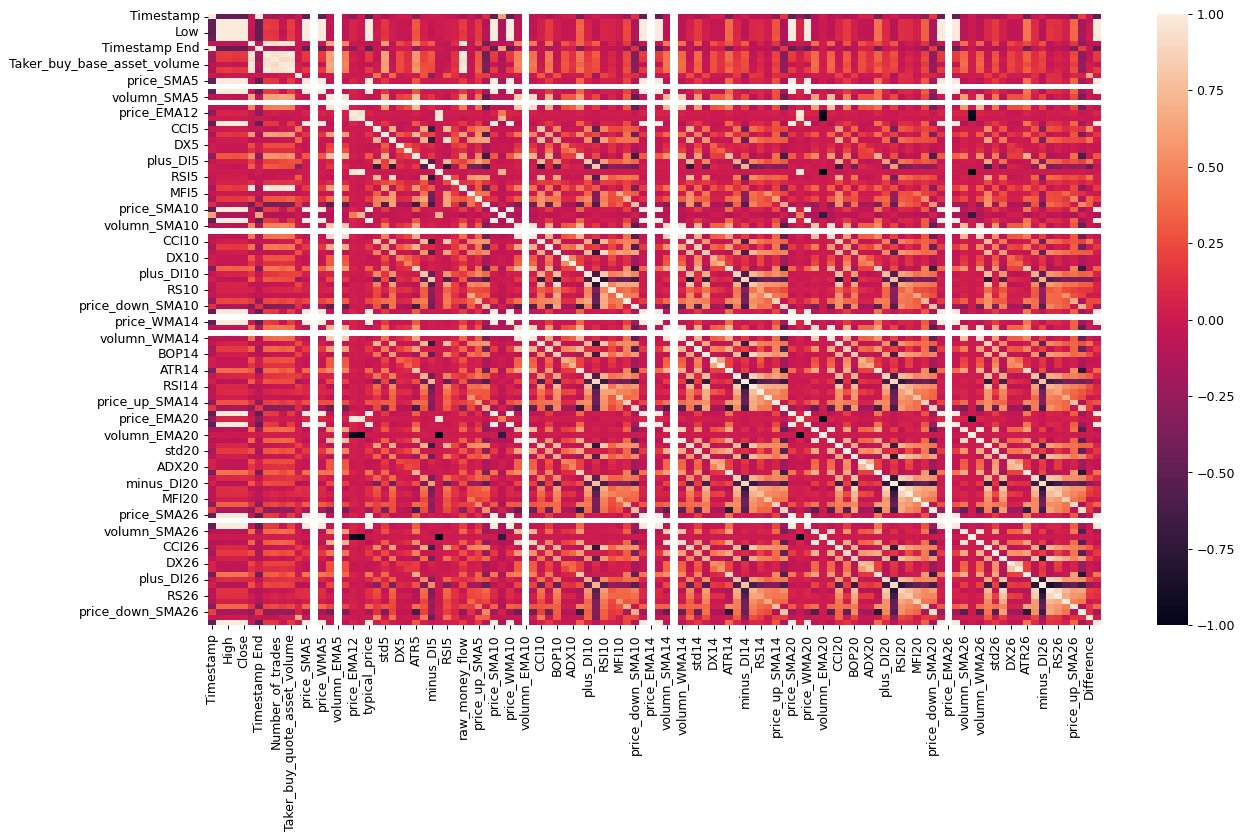

In [13]:
import seaborn as sns
plt.figure(figsize=(16,9), dpi=90)
sns.heatmap(corr)
plt.show()

In [16]:
m = corr["original_close"]

In [24]:
m.drop(index=["Open", "High", "Low", "Close", "original_close"], inplace=True)

In [27]:
m[abs(m)>0.4]

Timestamp       -0.494887
Timestamp End   -0.494887
price_SMA5       0.998165
price_WMA5       0.997785
typical_price    0.999087
price_SMA10      0.996747
price_WMA10      0.996944
price_SMA14      0.995591
price_WMA14      0.996254
price_SMA20      0.993855
price_WMA20      0.995216
ATR20            0.400915
price_SMA26      0.992072
price_WMA26      0.994161
ATR26            0.422651
Name: original_close, dtype: float64

In [48]:
df = df[df["Timestamp"] >= 1609506000000]

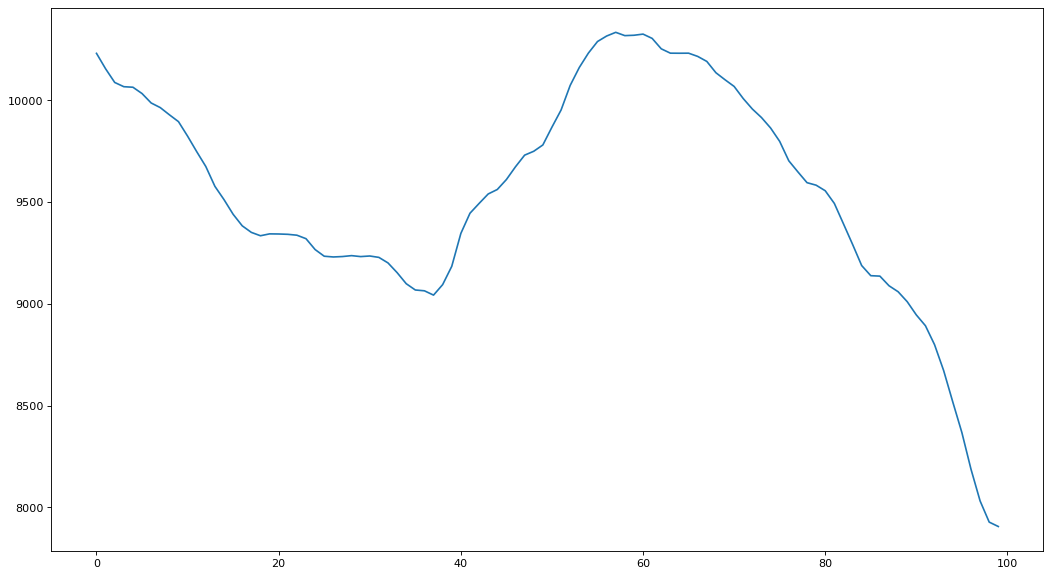

In [52]:
standard_deviation = []
for i in range(0, 5000, 50):
    standard_deviation.append(df.iloc[i:i+5000,:]["Close"].std())

plt.figure(figsize=(16,9), dpi=80)
plt.plot(standard_deviation)
plt.show()

In [46]:
plt.figure(figsize=(16,9), dpi=80)
plt.plot([])
plt.show()

,Timestamp,Open,High,Low,Close,Volumn,Timestamp End,Quote_asset_volume,Number_of_trades,Taker_buy_base_asset_volume,...,ADX26,ATR26,plus_DI26,minus_DI26,RSI26,RS26,MFI26,price_up_SMA26,price_down_SMA26,Difference
26604,1627966440000,38537.82,38537.82,37955.52,38292.36,4758.792378,1627970039999,1.818304e+08,86722,1974.702291,...,28.203352,474.293462,346.714100,843.778884,37.433890,0.598309,45.951485,82.621923,-138.092308,-245.46
26605,1627970040000,38292.37,38441.25,38199.69,38439.46,1335.793915,1627973639999,5.121722e+07,33238,751.077112,...,26.542074,474.024231,346.911023,723.066331,39.389509,0.649879,42.578251,88.279615,-135.840000,147.09
26606,1627973640000,38441.24,38665.75,38252.40,38580.59,2090.041530,1627977239999,8.047839e+07,42642,1027.492902,...,41.499106,481.210769,433.242110,707.004687,40.171768,0.671452,48.013304,91.210000,-135.840000,139.35
26607,1627977240000,38580.60,38666.00,38315.00,38555.04,1657.963395,1627980839999,6.386799e+07,35299,737.383032,...,34.726739,467.941538,293.338747,727.052936,34.388135,0.524115,50.319782,71.710769,-136.822692,-25.56
26608,1627980840000,38559.27,38607.69,38340.00,38585.52,1397.382074,1627984439999,5.379679e+07,33952,687.460868,...,24.720433,460.239231,265.950735,739.220489,35.690662,0.554984,51.009685,72.883077,-131.324615,26.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33250,1651892040000,35968.65,35974.33,35760.00,35889.40,896.214420,1651895639999,3.214347e+07,22739,409.205980,...,31.364130,320.878077,294.944881,666.635662,44.366105,0.797465,58.556861,53.511154,-67.101538,-79.25
33251,1651895640000,35889.40,35890.23,35755.85,35819.05,995.509940,1651899239999,3.565444e+07,24661,490.635660,...,34.217571,313.908846,256.465314,627.872741,39.278091,0.646852,59.590750,45.155000,-69.807308,-70.35
33252,1651899240000,35819.06,35897.44,35722.24,35858.28,966.414510,1651902839999,3.462155e+07,23920,445.316230,...,38.782773,316.458077,258.868413,642.336389,40.197731,0.672177,57.865866,46.663846,-69.421923,39.22
33253,1651902840000,35858.27,35909.75,35794.31,35795.55,882.049590,1651906439999,3.162087e+07,23246,408.638960,...,42.019594,313.700385,264.897054,614.939414,40.563962,0.682481,57.284599,46.663846,-68.373846,-62.72


In [44]:
df

,Open,High,Low,Close,Volumn,Timestamp End,Quote_asset_volume,Number_of_trades,Taker_buy_base_asset_volume,Taker_buy_quote_asset_volume,...,smoothed_minus_DM72,mad72,ATR72,CCI72,plus_DI72,minus_DI72,DX72,ADX72,BOP72,MFI72
29650,0.004540,0.017235,0.004439,0.019374,0.532040,0.000002,0.537759,0.418944,0.539811,0.545324,...,0.000000,0.009546,0.018025,-0.837728,0.175421,-0.018355,-1.081355,0.044214,0.449039,0.018680
29651,0.019393,0.016435,0.018984,0.010320,0.212834,0.000002,0.226193,0.171987,0.186414,0.200206,...,-0.000150,-0.002838,0.012559,-10.093299,0.065256,-0.012870,-0.719050,-0.175332,0.036028,0.003094
29652,0.010301,-0.004791,0.005288,-0.000321,-1.677082,0.000002,-1.679525,-0.574278,-1.731578,-1.732570,...,0.000000,-0.005498,-0.001238,-0.164088,-0.145515,0.001236,0.550533,-1.078411,-0.146849,0.014050
29653,-0.000321,-0.000582,0.002995,0.001557,-0.020937,0.000002,-0.020387,-0.555460,0.066643,0.066952,...,0.000000,-0.010893,-0.009975,5.440470,-0.036368,0.009876,0.153621,-0.680475,-1.971548,0.018196
29654,0.001426,0.006583,-0.001605,-0.004287,0.441979,0.000002,0.443102,0.405888,0.373533,0.374934,...,0.015682,-0.013163,0.005079,0.669279,0.051312,0.010657,-0.164391,0.544037,-1.275711,0.002209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33089,-0.001764,-0.001947,-0.004930,-0.003949,0.272611,0.000002,0.270233,0.172645,0.264792,0.262406,...,0.046407,0.014027,0.002478,0.040115,-0.014637,0.044038,0.091338,0.020447,0.372390,-0.007924
33090,-0.003949,-0.002155,-0.000960,-0.001835,0.084734,0.000002,0.083393,0.061105,0.128601,0.127348,...,-0.016921,0.013365,0.000286,0.001658,-0.000286,-0.017211,-0.026241,0.017201,0.099195,-0.007634
33091,-0.001835,0.000483,-0.000097,0.004243,-0.157282,0.000002,-0.156267,-0.110975,-0.180465,-0.179518,...,-0.003703,0.011113,0.000471,-0.060031,-0.002178,-0.004176,-0.003132,0.089746,-0.102586,0.000643
33092,0.004244,0.000272,0.001894,-0.002588,-0.007162,0.000002,-0.007013,0.031131,-0.039379,-0.039185,...,-0.000471,0.007527,-0.009470,-0.024373,-0.068093,0.008914,0.104287,-0.025921,0.364943,0.001334
